In [8]:
import nltk
nltk.download('punkt', download_dir='D:/skola/D7041E/Lab3/utils/')
nltk.data.path.append('D:/skola/D7041E/Lab3/utils/')

d=1000

[nltk_data] Downloading package punkt to
[nltk_data]     D:/skola/D7041E/Lab3/utils/...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
import os
import pandas as pd
import glob
import re
from nltk.tokenize import word_tokenize
import hashlib
import csv

BASE_DIR = 'training_data3' # training_data2 represents the 10K version, since the 100K version is too heavy, computational-wise. training_data3 is 10K-news version!
TEST_DIR = 'test_data/txt/'
LANGUAGES = ['bul','ces','dan','deu','ell','eng','est','fin','fra','hun','ita','lav','lit','nld','pol','por','ron','slk','slv','spa','swe']

def extract_text_from_file(file_path):
    text_content = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = re.sub(r'<[^>]+>', '', line).strip()  # remove tags and whitespaces
            if line:
                text_content.append(line)
    return ' '.join(text_content)

import csv

def load_language_data(directory, languages, file_pattern="*sentences.txt"):
    data = []
    total_languages = len(languages)
    
    for idx, lang in enumerate(languages, start=1):
        search_pattern = os.path.join(directory, f"*{lang}*", file_pattern).replace("\\", "/")
        file_paths = glob.glob(search_pattern)
        
        if file_paths:
            file_path = file_paths[0]
            print(f"[{idx}/{total_languages}] Loading data for {lang} from {file_path}")
            
            cleaned_rows = []
            with open(file_path, 'r', encoding='utf-8') as f:
                reader = csv.reader(f, delimiter='\t')
                for row in reader:
                    if len(row) == 2 and row[1].strip():  # we ensure two columns and non-empty text
                        cleaned_rows.append(row)

            # convert to dataframe because of the built-in functions (proved to not be neccessary in the end....)
            df = pd.DataFrame(cleaned_rows, columns=['id', 'text'])
            df['language'] = lang  # add language column
            data.append(df[['text', 'language']])
        else:
            print(f"[{idx}/{total_languages}] No file found for language: {lang}")
    
    if data:
        # combine all language dataFrames
        all_data = pd.concat(data, ignore_index=True)
        print("Data loaded successfully.")
        
        # drop rows with missing or invalid text (otherwise our results will be skewed. this was only an issue in the danish training data file: [training_data3])
        all_data.dropna(subset=['text'], inplace=True)
        all_data = all_data[all_data['text'].str.strip().astype(bool)]  # Remove rows with only spaces
        return all_data
    else:
        print("No training files loaded.")
        return pd.DataFrame()

def load_test_data(test_dir, languages, file_limit=None):
    test_data = []
    total_languages = len(languages)
    
    for lang_idx, lang in enumerate(languages, start=1):
        language_dir = os.path.join(test_dir, lang)
        file_pattern = os.path.join(language_dir, "ep-*.txt")
        file_paths = glob.glob(file_pattern)
        
        if file_limit:
            file_paths = file_paths[:file_limit]
        
        print(f"[{lang_idx}/{total_languages}] Loading up to {file_limit} files for language {lang} (found {len(file_paths)} files)")

        for file_idx, file_path in enumerate(file_paths, start=1):
            print(f"  Processing file {file_idx}/{len(file_paths)}: {file_path}")
            text = extract_text_from_file(file_path)
            if text:
                test_data.append({'text': text, 'language': lang})
    if test_data:
        print('Test data loaded successfully.')
    else:
        print('No test data found.')
    return pd.DataFrame(test_data)

from unidecode import unidecode 

def preprocess_text_for_words(text):
    text = unidecode(text) # transliterate cyrillic characters to latin (specified in the lecture)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
    text = text.lower()
    tokens = word_tokenize(text, preserve_line=True)
    return ' '.join(tokens)

def preprocess_training(train_data_path):
    if os.path.exists(train_data_path):
        print("Loading preprocessed training data from disk.")
        all_training_data = pd.read_pickle(train_data_path)
    else:
        all_training_data = load_language_data(BASE_DIR, LANGUAGES)
        print("Initiating preprocessing step for training data")
        all_training_data['text'] = all_training_data['text'].apply(preprocess_text_for_words)
        print("Training data preprocessing complete.")
        all_training_data.to_pickle(train_data_path)
    return all_training_data

def preprocess_test(test_data_path):
    if os.path.exists(test_data_path):
        print("Loading preprocessed test data from disk.")
        all_test_data = pd.read_pickle(test_data_path)
    else:
        all_test_data = load_test_data(TEST_DIR, LANGUAGES, file_limit=5)
        print("Initiating preprocessing step for test data")
        all_test_data['text'] = all_test_data['text'].apply(preprocess_text_for_words)
        print("Test data preprocessing complete.")
        all_test_data.to_pickle(test_data_path)
    return all_test_data

In [10]:
# load and preprocess training data if not already saved
train_data_path = 'preprocessed_training_data.pkl'
test_data_path = 'preprocessed_test_data.pkl'

all_training_data = preprocess_training(train_data_path)
all_test_data = preprocess_test(test_data_path)

# verify structure: debug prints
print(all_training_data.sample(5))
print(all_test_data.sample(5))

print(all_training_data['language'].value_counts())
print(all_test_data['language'].value_counts())


[1/21] Loading data for bul from training_data3\bul_news_2022_10K\bul_news_2022_10K-sentences.txt
[2/21] Loading data for ces from training_data3\ces_news_2022_10K\ces_news_2022_10K-sentences.txt
[3/21] Loading data for dan from training_data3\dan_news_2022_10K\dan_news_2022_10K-sentences.txt
[4/21] Loading data for deu from training_data3\deu_news_2023_10K\deu_news_2023_10K-sentences.txt
[5/21] Loading data for ell from training_data3\ell_news_2022_10K\ell_news_2022_10K-sentences.txt
[6/21] Loading data for eng from training_data3\eng_news_2023_10K\eng_news_2023_10K-sentences.txt
[7/21] Loading data for est from training_data3\est_news_2022_10K\est_news_2022_10K-sentences.txt
[8/21] Loading data for fin from training_data3\fin_news_2022_10K\fin_news_2022_10K-sentences.txt
[9/21] Loading data for fra from training_data3\fra_news_2023_10K\fra_news_2023_10K-sentences.txt
[10/21] Loading data for hun from training_data3\hun_news_2023_10K\hun_news_2023_10K-sentences.txt
[11/21] Loading dat

In [11]:
import numpy as np
from nltk import ngrams
from collections import defaultdict
import pickle
import hashlib

def generate_random_vector(d, seed=None):
    if seed is not None:
        np.random.seed(seed)
    return np.random.choice([-1, 1], size=d)

ngram_vectors = defaultdict(lambda: generate_random_vector(d))

def create_language_vector(texts, ngram_vectors, d, n=3):
    language_vector = np.zeros(d)  # init l-v
    for text in texts:
        n_grams = create_ngrams(text, n)  # gen. n-grams from the text
        #print(f"Text: {text[:50]}...")  # debugging
        #print(f"N-Grams: {n_grams[:5]} (showing first 5)")  # first 5 n-grams
        
        for n_gram in n_grams:
            # if n_gram not in ngram_vectors:
            #     print(f"New n-gram encountered: {n_gram}")
            language_vector += ngram_vectors[n_gram]
    
    # norm
    norm = np.linalg.norm(language_vector)
    if norm > 0:
        language_vector /= norm
    
    print(f"Language Vector Norm: {np.linalg.norm(language_vector):.4f}")
    return language_vector

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def create_query_vector(text, ngram_vectors, d, n=3):
    query_vector = np.zeros(d)
    n_grams = create_ngrams(text, n)
    for n_gram in n_grams:
        query_vector += ngram_vectors[n_gram]
    # norm
    if np.linalg.norm(query_vector) > 0:
        query_vector /= np.linalg.norm(query_vector)
    return query_vector

def predict_language(query_text, language_vectors, ngram_vectors, d, n=3):
    query_vector = create_query_vector(query_text, ngram_vectors, d, n)
    similarities = {lang: cosine_similarity(query_vector, vec) for lang, vec in language_vectors.items()}
    predicted_language = max(similarities, key=similarities.get)
    return predicted_language, similarities

def save_language_vectors(language_vectors, d):
    filename = f'language_vectors_d{d}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(language_vectors, f)
    print(f"Language vectors saved to {filename}")

def create_ngrams(text, n=3):
    #tokens = word_tokenize(text, preserve_line=True)
    #return [' '.join(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]
    return [text[i:i+n] for i in range(len(text) - n + 1)]

def load_language_vectors(d):
    filename = f'language_vectors_d{d}.pkl'
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            print(f"Loading precomputed language vectors from {filename}")
            return pickle.load(f)
    else:
        print(f"No precomputed language vectors found for d={d}. Recomputing...")
        return None

def save_ngram_vectors(ngram_vectors, d):
    filename = f'ngram_vectors_d{d}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(dict(ngram_vectors), f)
    print(f"Saved n-gram vectors to {filename}")

def load_ngram_vectors(d):
    filename = f'ngram_vectors_d{d}.pkl'
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            print(f"Loaded n-gram vectors from {filename}")
            return defaultdict(lambda: generate_random_vector(d), pickle.load(f))
    else:
        print(f"No precomputed n-gram vectors found for d={d}. Recomputing...")
        return None

In [12]:
# generate and save language vectors for all languages
n = 3
language_vectors = {}


for lang in all_training_data['language'].unique():
    print(f"Processing language: {lang}")
    language_texts = all_training_data[all_training_data['language'] == lang]['text'].tolist()
    language_vector = create_language_vector(language_texts, ngram_vectors, d, n)
    language_vectors[lang] = language_vector

    # save vector: i needed this for my slow computer :=)
    with open(f'language_vector_{lang}.pkl', 'wb') as f:
        pickle.dump(language_vector, f)

print("All language vectors generated and saved!")

Processing language: bul
Language Vector Norm: 1.0000
Processing language: ces
Language Vector Norm: 1.0000
Processing language: dan
Language Vector Norm: 1.0000
Processing language: deu
Language Vector Norm: 1.0000
Processing language: ell
Language Vector Norm: 1.0000
Processing language: eng
Language Vector Norm: 1.0000
Processing language: est
Language Vector Norm: 1.0000
Processing language: fin
Language Vector Norm: 1.0000
Processing language: fra
Language Vector Norm: 1.0000
Processing language: hun
Language Vector Norm: 1.0000
Processing language: ita
Language Vector Norm: 1.0000
Processing language: lav
Language Vector Norm: 1.0000
Processing language: lit
Language Vector Norm: 1.0000
Processing language: nld
Language Vector Norm: 1.0000
Processing language: pol
Language Vector Norm: 1.0000
Processing language: por
Language Vector Norm: 1.0000
Processing language: ron
Language Vector Norm: 1.0000
Processing language: slk
Language Vector Norm: 1.0000
Processing language: slv
Lan

In [13]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize variables for evaluation
correct_predictions = 0
total_samples = len(all_test_data)
actual_labels = []
predicted_labels = []

print("\nStarting language prediction for test data...\n")

for idx, row in all_test_data.iterrows():
    query_text = row['text']
    actual_language = row['language']
    
    # gen q-v
    query_vector = create_query_vector(query_text, ngram_vectors, d, n)
    
    # calc sim
    similarities = {lang: cosine_similarity(query_vector, vec) for lang, vec in language_vectors.items()}
    predicted_language = max(similarities, key=similarities.get)
    
    # needed for matrix
    actual_labels.append(actual_language)
    predicted_labels.append(predicted_language)
    
    # correct or not
    if predicted_language == actual_language:
        correct_predictions += 1
    
    # debugggg
    if idx < 5:
        print(f"Test Sample {idx + 1}:")
        print(f"Actual Language: {actual_language}")
        print(f"Predicted Language: {predicted_language}")
        print(f"Cosine Similarities: {similarities}")
        print()


Starting language prediction for test data...

Test Sample 1:
Actual Language: bul
Predicted Language: bul
Cosine Similarities: {'bul': np.float64(0.3267555563855065), 'ces': np.float64(0.26618193358813086), 'dan': np.float64(0.07681245123429599), 'deu': np.float64(0.042503689541966934), 'ell': np.float64(0.19184117730331637), 'eng': np.float64(0.09546362884299174), 'est': np.float64(0.16739061486237197), 'fin': np.float64(0.1524451096886986), 'fra': np.float64(0.11694528412271811), 'hun': np.float64(0.08305029058275011), 'ita': np.float64(0.16283675874987302), 'lav': np.float64(0.20947264342258534), 'lit': np.float64(0.19091561706822904), 'nld': np.float64(0.057874028883190994), 'pol': np.float64(0.1787782475006649), 'por': np.float64(0.2126420777955524), 'ron': np.float64(0.1438070251350911), 'slk': np.float64(0.274338274203985), 'slv': np.float64(0.2712113022022858), 'spa': np.float64(0.16559401046837663), 'swe': np.float64(0.15556476616532391)}

Test Sample 2:
Actual Language: bul

# Constructing high-dimensional centroids

## Question: What will be the size of the n-gram input vector in conventional representation?
The key idea here, as I've understood it, is that the total size of the vector depends on the size of the vocabulary. This would result in different sizes depending on if we are working with characters or words in our n-grams. In our case, using the latin alphabet as well as trigrams, we would get V^3 = 26^3 = 17 576. If we, instead, would work with words (like I've also tested) the vocabulary size could be *very* large, since we could have 10 000 unique words, which would mean V^3 = 10 000^3.

Finally, in practice, the number of observed 3-grams are much smaller compared to these theoretical calulations - much because of how I have limited the dataset (only using 10K for training, and five files for each test).

## Question: What are some difficulties working with conventional representations of n-grams in the machine learning context?
The most apparent one for me has been the high dimensionality required; with larger vocabularies (or potentially higher n-gram sizes), this can easily become impractical. Following the example I gave in the previous question: if we work with words as n-grams, and have 10 000 unique words, we would have 1 trillion possible trigrams for our vocabulary. This leads to massive *memory* and *storage* requirements, and also slow computation. This was an issue for me, since I initially worked with training data of 100K instead of 10K. While the accuracy was around 34% (seems low, but this was with word-wise trigrams, not character-wise) with d=100, I wasn't even able to run tests for d=1000 without my computer going OOM.

Then I realised, after switching to training data of size 10K, that the results for d=1000 are around the same as I had for d=100 with a training data size of 100K. What's the common factor? 10! Even if this was not a part of the question, I still found it interesting how there's a near-linear relationship between training data size and dimensionality, with respect to accuracy. This followed suit for the character-based trigrams as well, only that they were of a generally higher accuracy.

# Below are the results from this laboration, with the two dimensions in mind:
Since I'm still not sure if you will be able to see the outputs of the code without actually running it, here are the results in text-form. If you want to make sure these results are from the code, simply switch the value of 'd' at the top of the code to test both dimensionality values. Since we are not to upload any other files other than the jupyter notebook, you would have to put the training data in a folder called 'training_data3' and the test data in a folder called 'training_data', both local to the notebook. 


## Tests for d=100
1. Testing complete! Accuracy: 66.67% (70/105 correct)

## Tests for 1000
1. Testing complete! Accuracy: 89.52% (94/105 correct)


Testing complete! Accuracy: 89.52% (94/105 correct)

F1 Score (Weighted): 0.8928

Classification Report:
              precision    recall  f1-score   support

         bul       0.80      0.80      0.80         5
         ces       0.56      1.00      0.71         5
         dan       1.00      1.00      1.00         5
         deu       0.83      1.00      0.91         5
         ell       1.00      1.00      1.00         5
         eng       1.00      1.00      1.00         5
         est       1.00      0.60      0.75         5
         fin       1.00      1.00      1.00         5
         fra       1.00      1.00      1.00         5
         hun       1.00      1.00      1.00         5
         ita       1.00      1.00      1.00         5
         lav       0.80      0.80      0.80         5
         lit       1.00      0.60      0.75         5
         nld       1.00      1.00      1.00         5
         pol       1.00      0.80      0.89         5
         por       1.00      

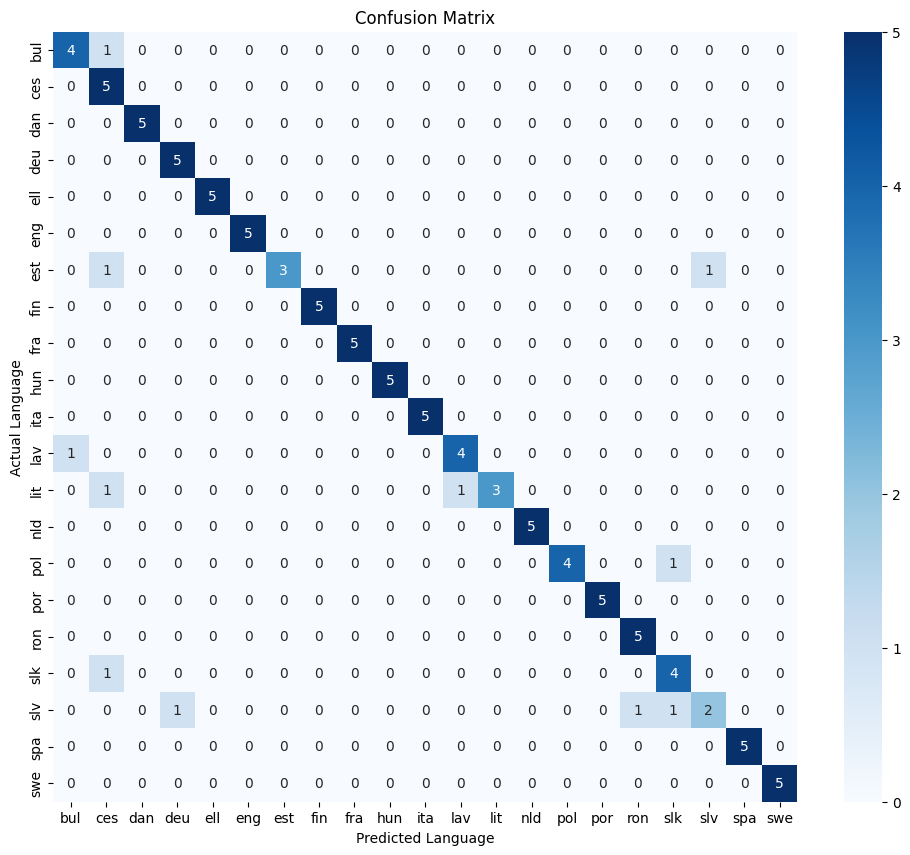

In [14]:
# accuracy
accuracy = correct_predictions / total_samples * 100
print(f"\nTesting complete! Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_samples} correct)")

# F1 Score
f1 = f1_score(actual_labels, predicted_labels, average='weighted')
print(f"\nF1 Score (Weighted): {f1:.4f}")

# classification report (i used it for debugging, but it provides neat results)
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels))

# confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=LANGUAGES)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LANGUAGES, yticklabels=LANGUAGES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Language")
plt.ylabel("Actual Language")
plt.show()

Note that each language has 5 query vectors each. This is because my RAM has limited my tests. Increasing the total amount of files we test against would most likely provide a more accurate result, but with d=1000, it would most likely not matter anyway, since the result is incredibly accurate either way.